## Install dependencies
Here we install Openslide:
https://openslide.org/

This library allows us to load the whole-slide images

In [41]:
!apt-get install openslide-tools --assume-yes
!apt-get install python-openslide --assume-yes
!pip install --upgrade setuptools==45.3
!pip install openslide-python==1.1.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-openslide is already the newest version (1.1.1-2ubuntu4).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Requirement already up-to-date: setuptools==45.3 in /usr/local/lib/python3.6/dist-packages (45.3.0)


## Helper Classes

In [0]:
import os
import numpy as np
import openslide

from shapely.geometry import Polygon, MultiPolygon
from json import JSONEncoder, loads, dumps


class Slide:
    """Implements common functions to most of the standard slides. It is based
    on openslide.
    """

    def __init__(self, filename):
        self.path = filename
        self.slide = openslide.OpenSlide(filename)

    @property
    def file_name(self):
        return os.path.split(self.path)[1]

    @property
    def size(self):
        """Returns the size (width, height) in pixels of the maximum
        magnification level
        """
        return self.slide.level_dimensions[0]

    @property
    def level_count(self):
        """Returns the number of zoom levels"""
        return self.slide.level_count

    def get_downsample_factor(self, level):
        """Returns the downsample factor of a level. For example the 
        downsample factor of level 0 is always 1, level 1 is usually 2...
        """
        return self.slide.level_downsamples[level]

    def get_level_size(self, level):
        """Returns the size in pixels (width, height) of a specific level of
        the slide
        """
        return self.slide.level_dimensions[level]

    def get_patch(self, x, y, size, level):
        """Returns an RBG array of a rectangular region"""
        ds = self.get_downsample_factor(level)
        return np.array(self.slide.read_region(location=(int(ds * x), int(ds * y)),
                                               size=size,
                                               level=level).convert(
                                                   mode='RGB'))
        
        
class Patch:
    """Class representing a rectangular region of a slide"""

    def __init__(self, slide, x, y, width, height, level):
        self.x, self.y = x, y
        self.width, self.height = width, height
        self.level = level
        self.slide = slide

        level_width, level_height = slide.get_level_size(level)
        self._polygon = Polygon.from_bounds(
            self.x / level_width, 
            self.y / level_height, 
            (self.x + self.width) / level_width, 
            (self.y + self.width) / level_height)
        
        rel_width = self.width / level_width
        rel_height = self.height / level_height

        self._internal_polygon = Polygon.from_bounds(
            self.x / level_width + 0.2 * rel_width, 
            self.y / level_height + 0.2 * rel_height, 
            (self.x + self.width) / level_width - 0.2 * rel_width, 
            (self.y + self.height) / level_height - 0.2 * rel_height)

    @property
    def polygon(self):
        return self._polygon

    @property
    def internal_polygon(self):
        return self._internal_polygon

    @property
    def size(self):
        return (self.width, self.height)

    def plot(self):
        points = np.array(self.polygon.exterior.coords)
        plt.plot(points[:,0], points[:,1])

    def get_image(self):
        ds = self.slide.get_downsample_factor(self.level)
        return self.slide.get_patch(int(self.x * ds), int(self.y * ds), self.size, self.level)

    def get_intersection(self, annotations):
        area = 0.0
        pol = Polygon()
        for annotation in annotations:
            pol = pol.union(annotation.polygon.intersection(self.polygon))
        return pol.area / self.polygon.area

    def get_internal_intersection(self, annotations):
        area = 0.0
        pol = Polygon()
        for annotation in annotations:
            pol = pol.union(annotation.polygon.intersection(self.internal_polygon))
        return pol.area / self.internal_polygon.area

## Mount google drive

In [43]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Patches Dataset + Data augmentation


Tumor patches: 9638
Normal patches: 46344
Tumor patches: 3457
Normal patches: 4000


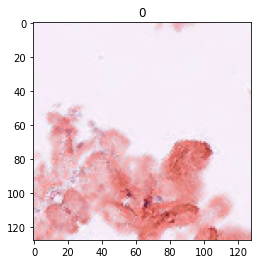

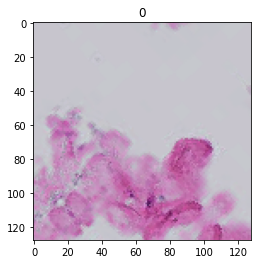

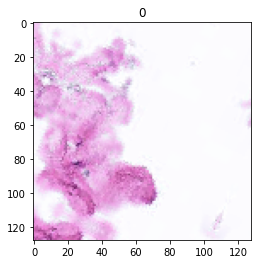

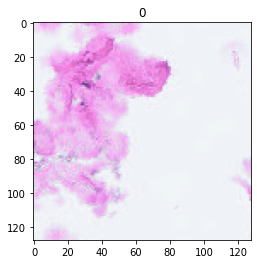

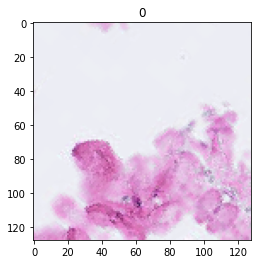

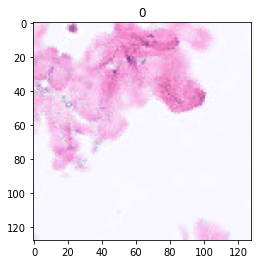

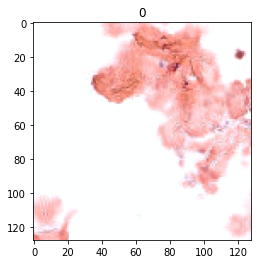

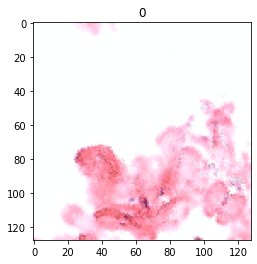

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset


class PatchesDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.copy()
        self.transforms = transforms
        self.slides = {}

    def load_image(self, row):
        if row['slide'] not in self.slides:
            self.slides[row['slide']] = Slide(row['slide'])
        slide = self.slides[row['slide']]
        x, y = row['x'], row['y']
        width, height  = row['width'], row['height']
        level = row['level']
        return slide.get_patch(x, y, (width, height), level)

    def __getitem__(self, item):
        row = self.df.iloc[item]
        image = self.load_image(row)

        if self.transforms is not None:
            image = self.transforms(image)
    
        return image, torch.tensor(data=row['target']).long(), item

    def __len__(self):
        return len(self.df)


def set_targets(df):
    df['target'] = (df['internal-tumor'] > 1e-3).astype(int)


results_path = "/content/drive/My Drive/Results"
dataset_path = "/content/drive/My Drive/Dataset A3"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


##################  Change these lines  ####################################
# TODO: Try some data augmentation

data_transforms = {
    'train': transforms.Compose([transforms.ToPILImage(),
                                 transforms.RandomVerticalFlip(),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Pad(padding=30, padding_mode='reflect'),
                                 transforms.RandomRotation(45),
                                 transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
                                 transforms.CenterCrop(128),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)]),
    'val': transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])
}

##################  Finish changing here  ##################################

datasets = {}

max_samples = 20000
pos_weight = 1.0

for phase in ['train', 'val']:
    df = pd.read_csv(os.path.join(dataset_path, f'{phase}.csv'))
    set_targets(df)

    print('Tumor patches: %d' % len(df[df['target'] == 1]))
    print('Normal patches: %d' % len(df[df['target'] == 0]))

    normal_df = df[df['target'] == 0]
    tumor_df = df[df['target'] == 1]

    normal_df = normal_df.sample(min(len(normal_df), max_samples), replace=True)

    if phase == 'train':
        pos_weight = len(normal_df)/len(tumor_df)

    df = pd.concat([normal_df, tumor_df])

    datasets[phase] = PatchesDataset(df, transforms=data_transforms[phase])


for i in range(10):
    image, target, idx = datasets['train'][0]
    plt.title(target.item())
    plt.imshow(np.clip(std * (np.array(image)).transpose(1, 2, 0) + mean, 0, 1))
    plt.show()

## Data loaders

In [45]:
from torch.utils.data import DataLoader


def visualize_batch(images, labels, ncols=8):
    nrows = (len(images) + ncols - 1) // ncols
    plt.figure(figsize=(15, 2 * nrows))
    for i in range(len(images)):
        plt.subplot(nrows, ncols, i+1)
        plt.title(labels[i])
        plt.imshow(np.clip(std * np.array(images[i]).transpose(1, 2, 0) + mean, 0, 1))
        plt.axis('off')
    plt.show()


loaders = {}
batch_size = 64
workers = 8

for part in ['train', 'val']:
    loaders[part] = DataLoader(
        datasets[part], 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=workers, 
        drop_last=True)
    

images, labels, idx = next(iter(loaders['train']))
visualize_batch(images, labels)

## Create the neural network, set the hyperparameters, the loss function and the optimizer

In [46]:
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import models


##################  Change these lines  ####################################
# TODO: Define the network architecture

model = models.vgg11(pretrained=True)

model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, 2),
        )

##################  Finish changing here  ##################################

# learning rate
lr = 0.001

# number of epochs
n_epochs = 10

# try other optimizer??
optimizer = Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# set device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

# loss function
lossf = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight]).to(device))

cuda


## Train the network

In [0]:
import IPython.display

####### statistics part #########

loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

batch_loss = []
batch_acc = []


def plot_results(epoch, batch, total_batches):
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 4, 1)
    plt.title('Batch loss (epoch: %d, batch: %d/%d)' % (epoch, batch, total_batches))
    plt.plot(batch_loss)
    plt.yscale('log')
    plt.xlabel('step')

    plt.subplot(1, 4, 2)
    plt.title('Batch accuracy')
    plt.plot(batch_acc)
    plt.xlabel('step')

    plt.subplot(1, 4, 3)
    plt.title('loss')
    for phase in ['train', 'val']:
        plt.plot(loss_history[phase], label=phase)
        plt.yscale('log')
    plt.xlabel('epoch')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.xlabel('epoch')
    if len(acc_history['train']) > 0:
        plt.title('accuracy ' + ','.join(['%s: %.3f' % (phase, acc_history[phase][-1]) for phase in ['train', 'val']]))
    else: 
        plt.title('accuracy')

    for phase in ['train', 'val']:
        plt.plot(acc_history[phase], label=phase)
    plt.legend()

    plt.tight_layout()
    plt.show(block=False)

####### end statistics part #########

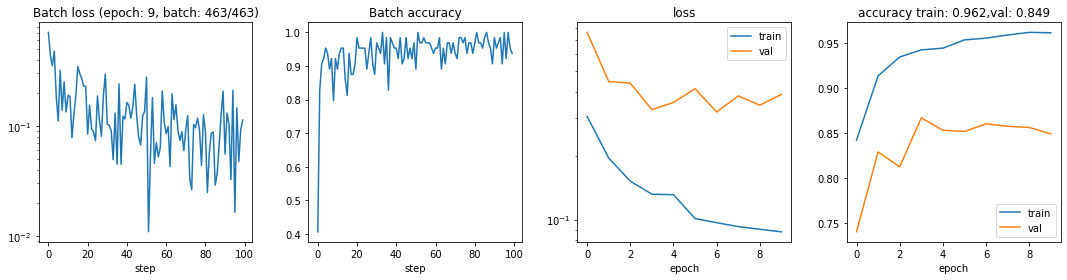

In [48]:
# number of batches in for the train and validation phases
num_batches = {'train': len(loaders['train']),
               'val': len(loaders['val'])}

best_acc = 0.0

# iterate on epochs
for i in range(n_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()  

        running_loss = 0.0
        running_acc = 0.0

        # iterate on batches
        for j, (samples, targets, idx) in enumerate(loaders[phase]):
            samples, targets = samples.to(device), targets.to(device)
            
            ##################  Change these lines  ####################################
            # TODO: compute the ouput of the network, the loss, do the backprop and an 
            # optimization step
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(samples)
                loss = lossf(outputs, targets)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            ##################  Finish changing here  ##################################

            acc = torch.sum(outputs.max(dim=1)[1] == targets).item() / batch_size
            running_loss += loss.item()
            running_acc += acc
            
            if j % 50 == 0 and phase == 'train':
                # track batch history
                batch_loss.append(loss.item())
                batch_acc.append(acc)
                plot_results(i, j, num_batches[phase])
        
        running_loss /= num_batches[phase]
        running_acc /= num_batches[phase]
        loss_history[phase].append(running_loss)
        acc_history[phase].append(running_acc)

        if phase == 'val' and running_acc > best_acc:
            torch.save(model.state_dict(), os.path.join(results_path, 'best_model.pt'))

    scheduler.step()
    plot_results(i, num_batches['train'], num_batches['train'])

In [49]:
model.load_state_dict(torch.load('/content/drive/My Drive/Results/best_model.pt'))

<All keys matched successfully>

## Confusion Matrix

In [50]:
import numpy as np

model.to(device)
model.eval()
matrix = np.zeros(shape=(2, 2), dtype=np.int)

bad_patches = []
bad_labels = []

th = 0.5

model.eval()
with torch.set_grad_enabled(False):
    matrix = np.zeros(shape=(2, 2))
    # iterate on batches
    for samples, targets, idx in loaders['val']:
        samples, targets = samples.to(device), targets.to(device)
        outputs = model(samples)
        pred = outputs.max(dim=1)[1]
        
        for i in range(targets.shape[0]):
            matrix[targets[i]][pred[i]] += 1
            bad_patches.append(samples[i].cpu())
            bad_labels.append(pred[i].cpu())

print(matrix)

[[3500.  487.]
 [ 627. 2810.]]


## Prediction examples

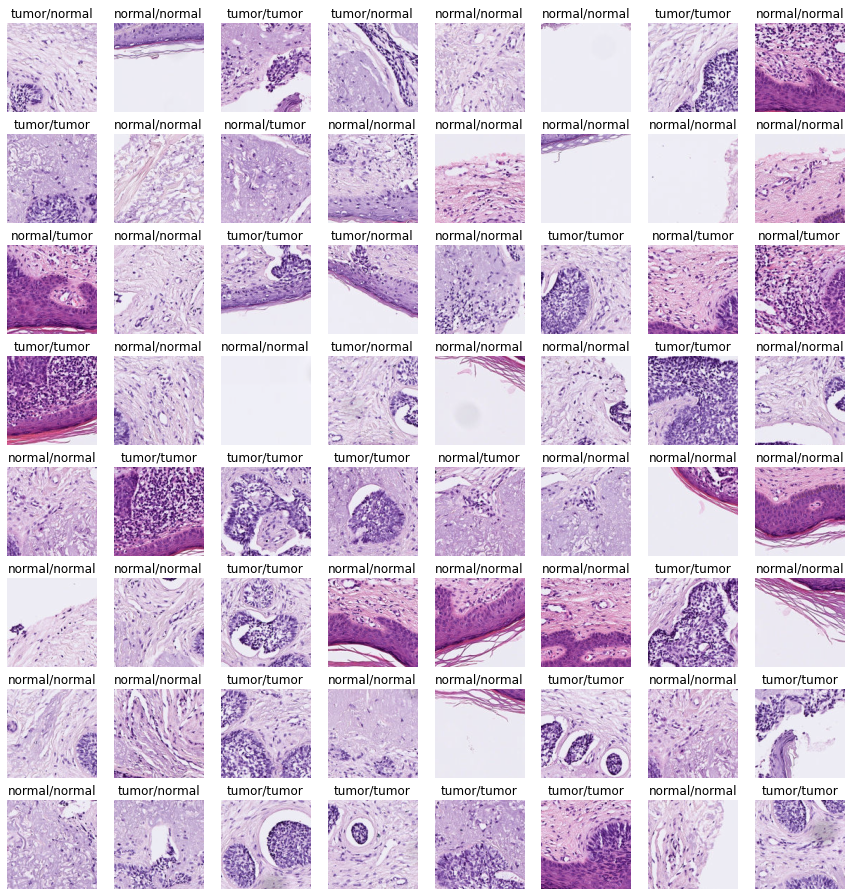

In [51]:
label_names=['normal', 'tumor']

model.eval()
with torch.set_grad_enabled(False):
    samples, targets, idx = next(iter(loaders['val']))
    outputs = model(samples.to(device))
    pred = outputs.max(dim=1)[1]
    visualize_batch(samples, ['%s/%s' % (label_names[targets[i]], label_names[pred[i]]) for i in range(len(labels))])

## Probabilities of some samples

0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


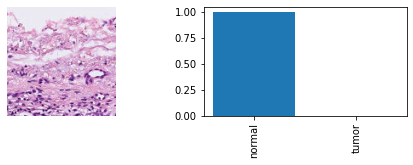

1


2


3


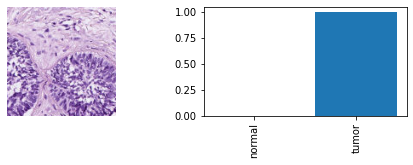

4


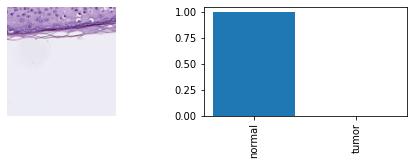

5


6


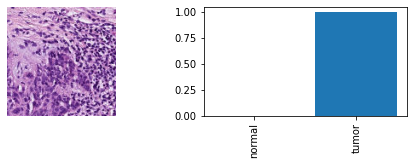

7


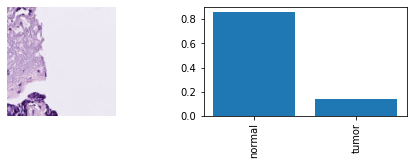

8


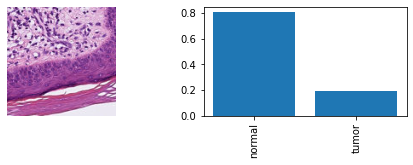

9


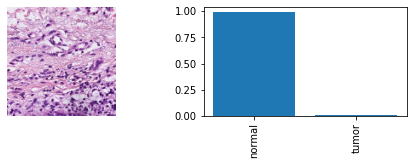

In [52]:
import torch.nn.functional as F
import numpy as np


model.eval()
with torch.set_grad_enabled(False):

    samples, targets , idx = next(iter(loaders['val']))
    samples, targets = samples.to(device), targets.to(device)
    outputs = model(samples)
    
    for i in range(min(10, targets.shape[0])):
        plt.figure(figsize=(8, 2))
        
        plt.subplot(1, 2, 1)
        print(i)
        # plt.imshow(std * samples[i].cpu().permute(1, 2, 0).squeeze() + mean, interpolation='bilinear')
        plt.imshow(np.clip(std * np.array(samples[i].cpu()).transpose(1, 2, 0) + mean, 0, 1))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        
        p = F.softmax(outputs[i].detach().squeeze()).cpu()
        plt.bar(range(len(p)), p)
        plt.xticks(range(len(p)), label_names, rotation='vertical')
        plt.show()


## Visualize wrongly classified patches

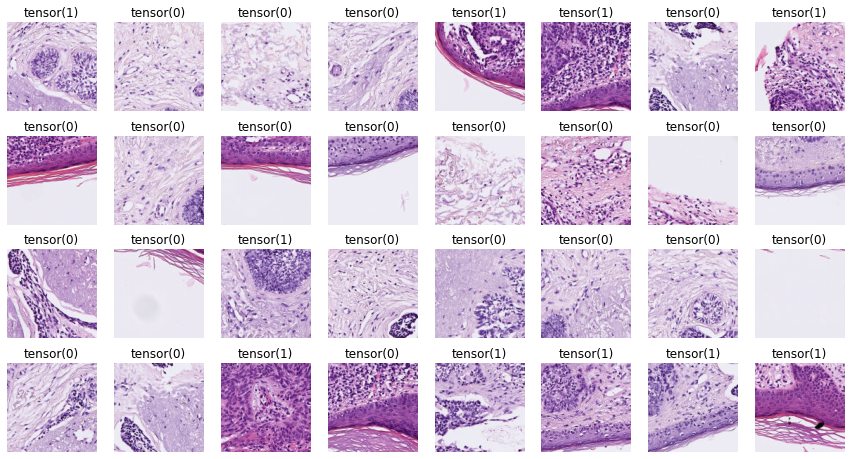

In [53]:
visualize_batch(bad_patches[:32], bad_labels[:32])

## Generate heatmaps

a) In order to make this code work the dataset should also return the index of the patch in the dataframe

/content/drive/My Drive/Dataset A3/Train/patient01.ndpi
(252, 690)


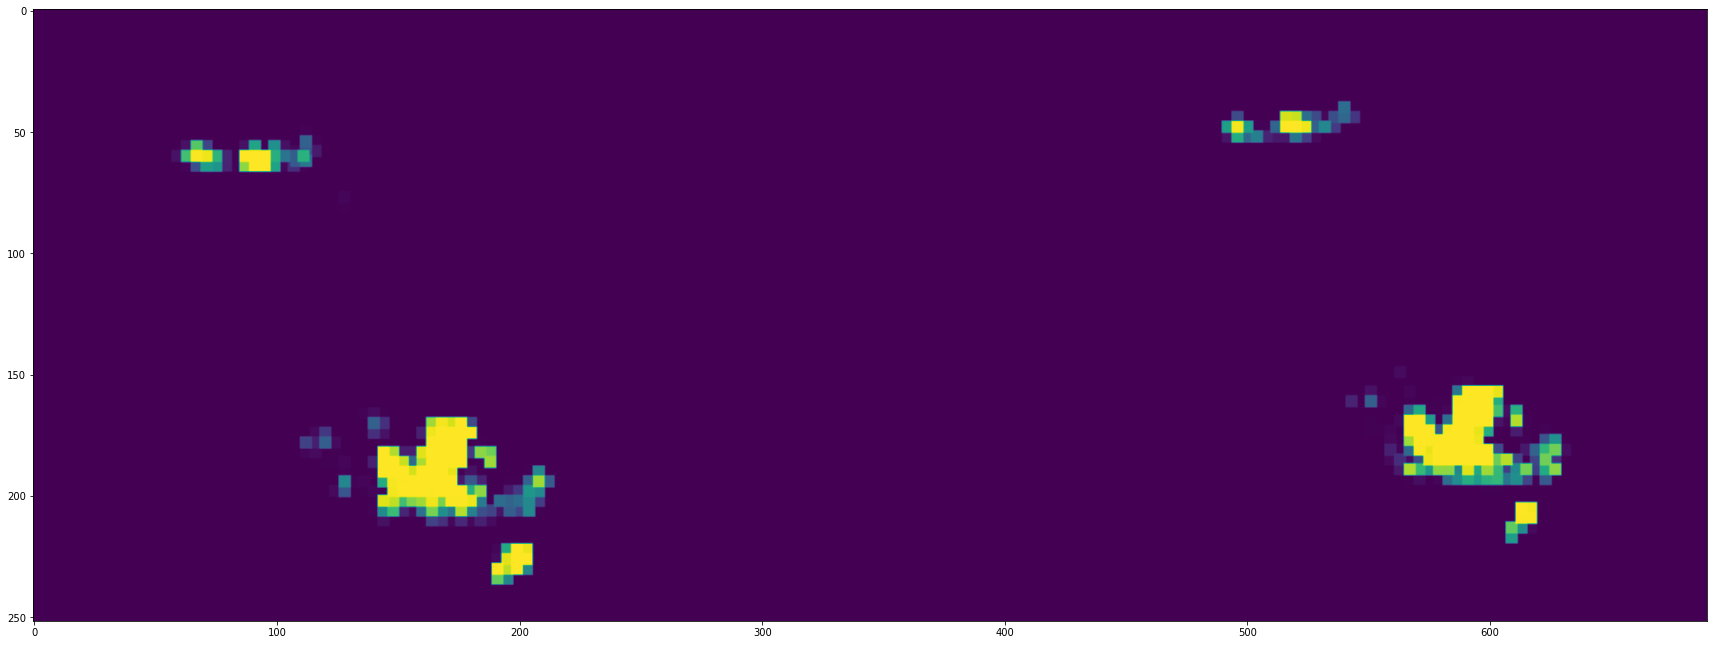

/content/drive/My Drive/Dataset A3/Train/patient02.ndpi
(198, 690)


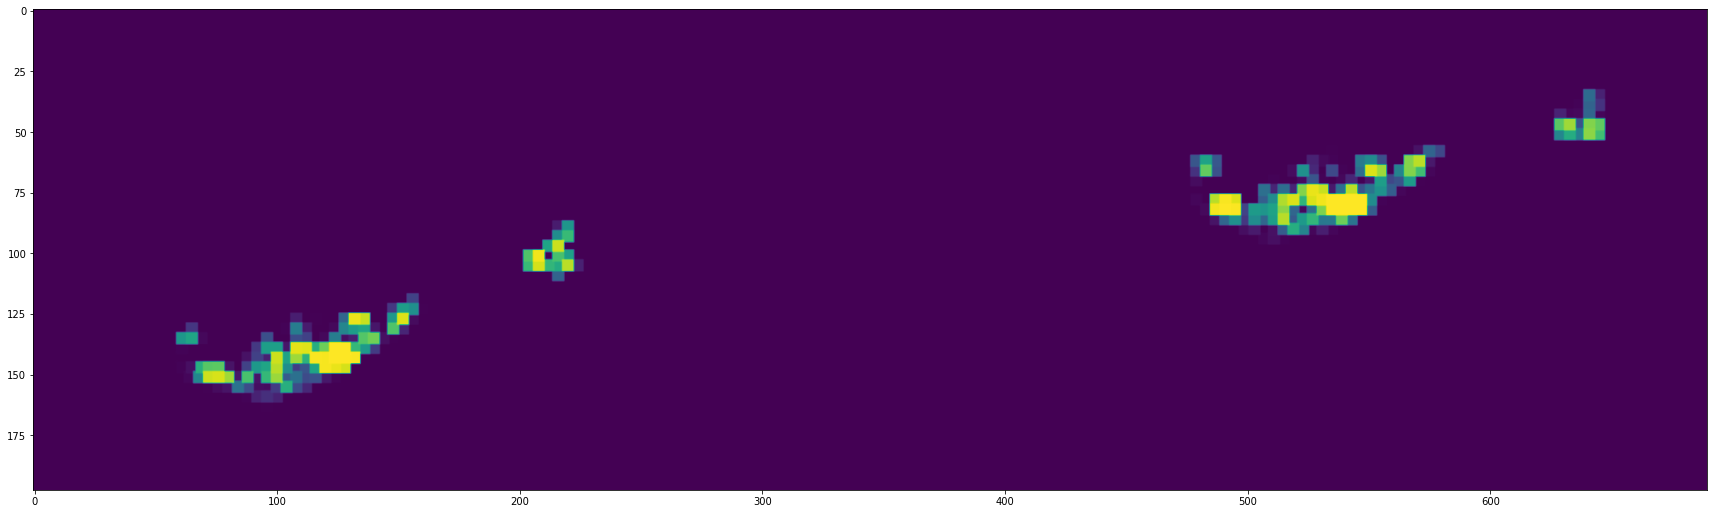

/content/drive/My Drive/Dataset A3/Train/patient03.ndpi
(594, 1260)


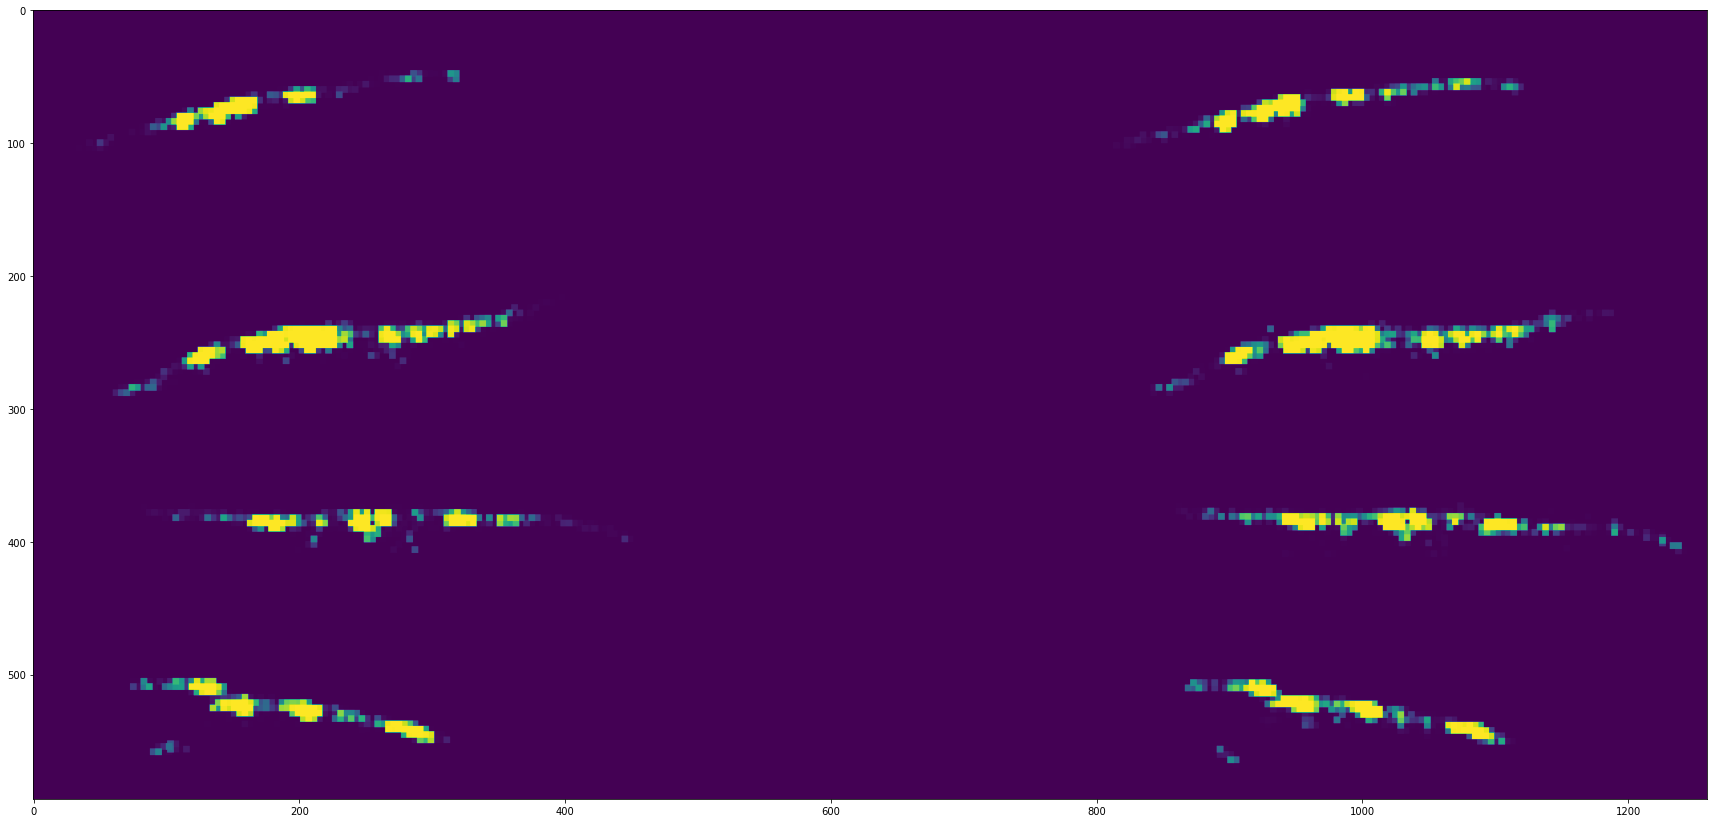

/content/drive/My Drive/Dataset A3/Train/patient04.ndpi
(378, 1350)


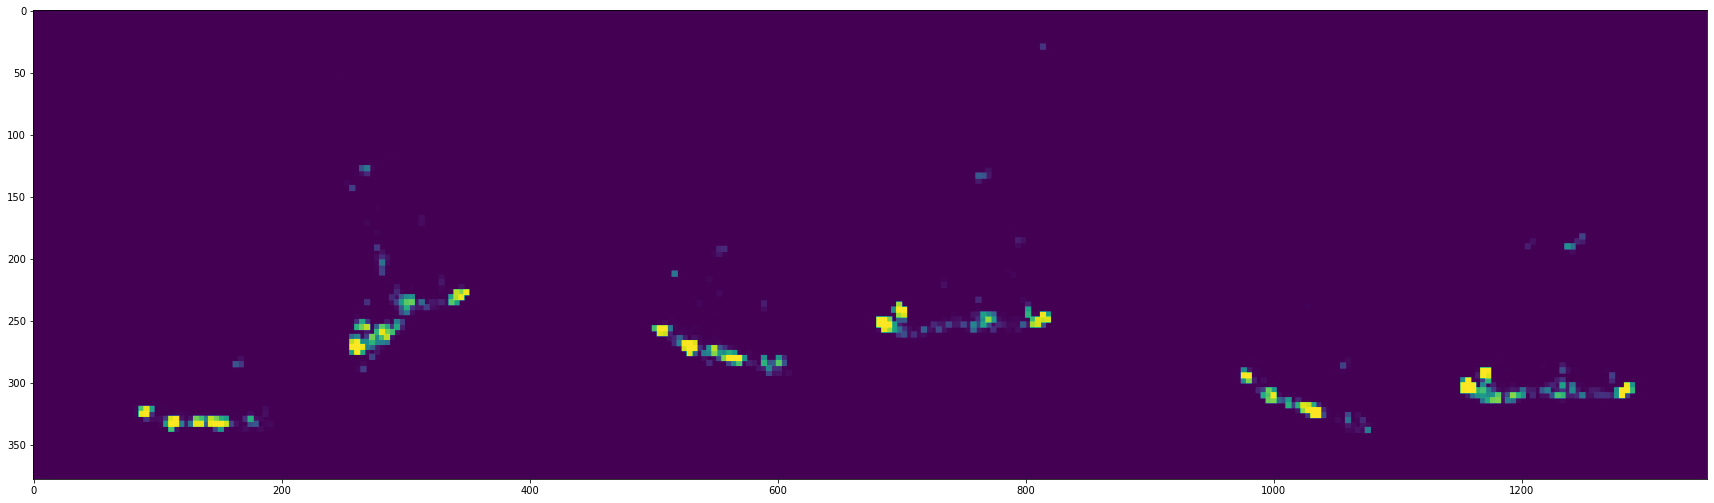

/content/drive/My Drive/Dataset A3/Train/patient05.ndpi
(396, 1530)


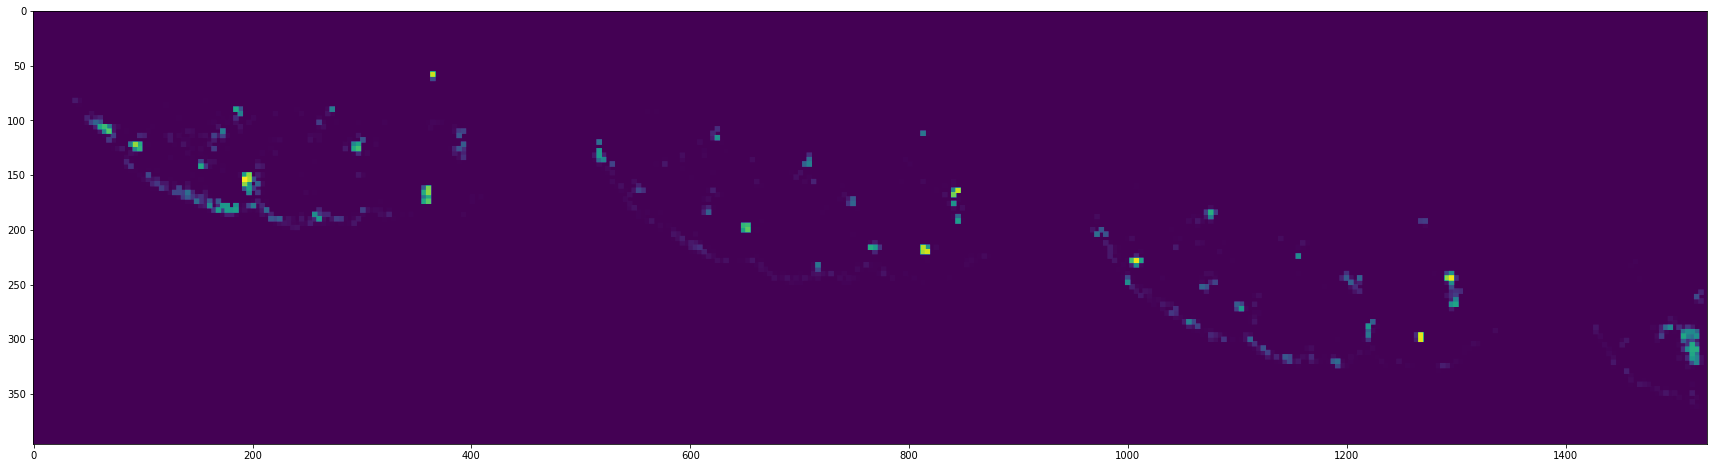

/content/drive/My Drive/Dataset A3/Train/patient06.ndpi
(504, 1560)


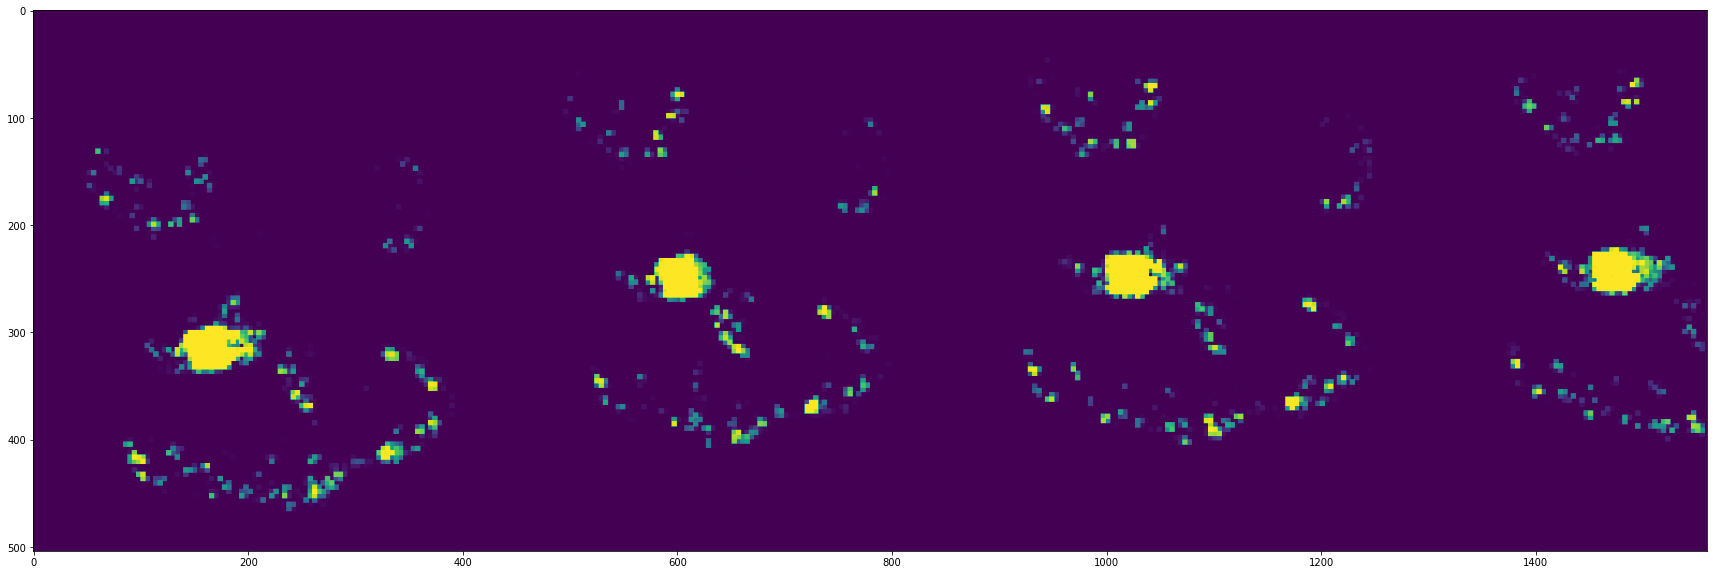

/content/drive/My Drive/Dataset A3/Train/patient07.ndpi
(288, 690)


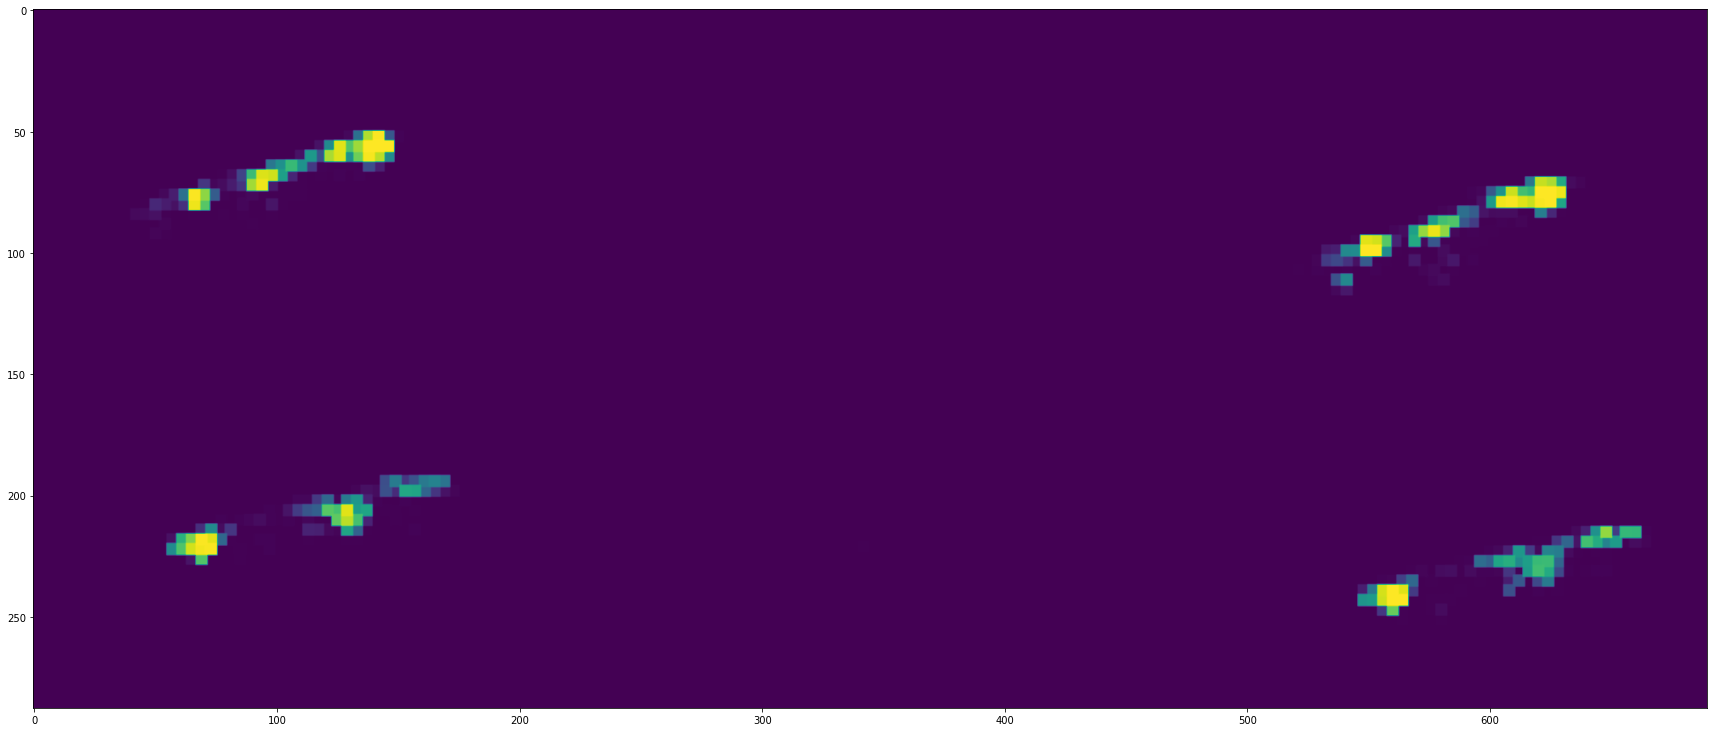

/content/drive/My Drive/Dataset A3/Validation/patient08.ndpi
(198, 690)


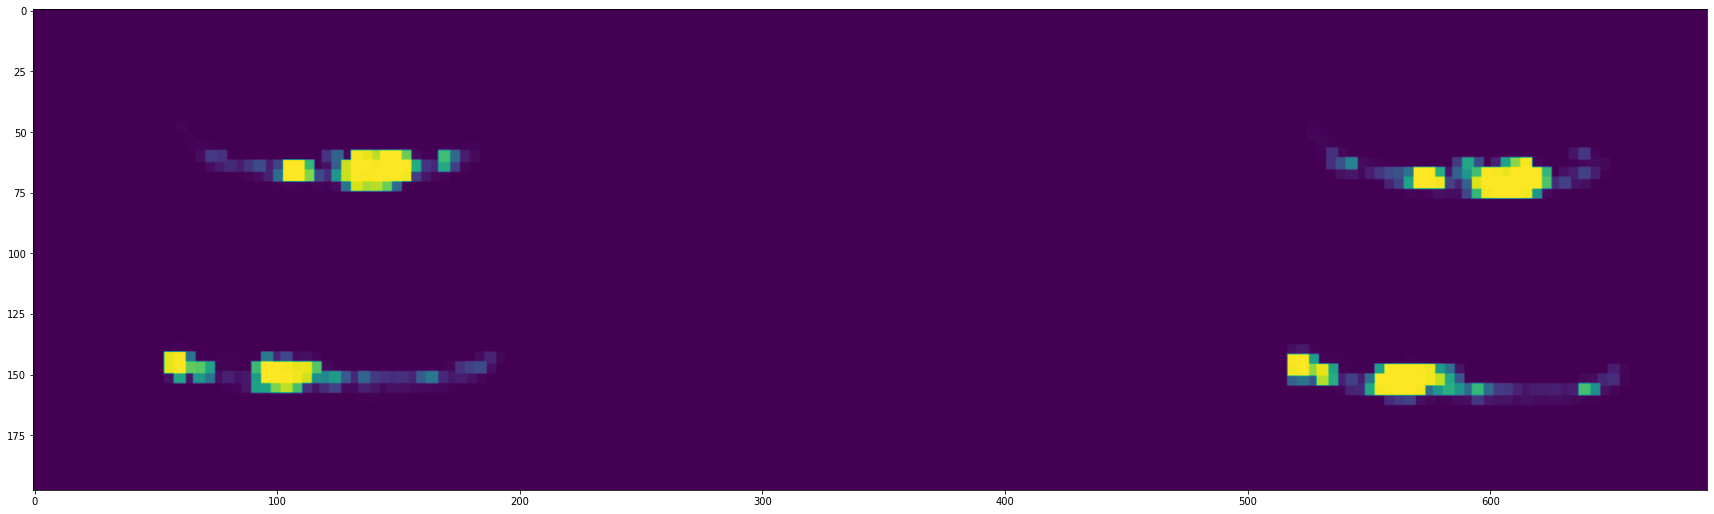

/content/drive/My Drive/Dataset A3/Validation/patient09.ndpi
(270, 1320)


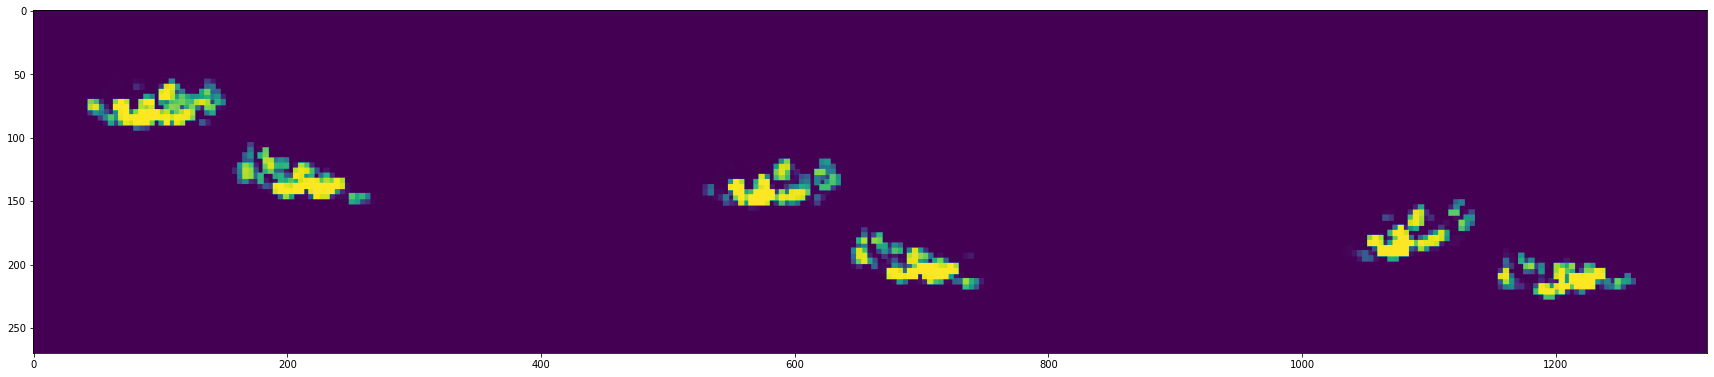

/content/drive/My Drive/Dataset A3/Test/patient10.ndpi
(612, 1470)


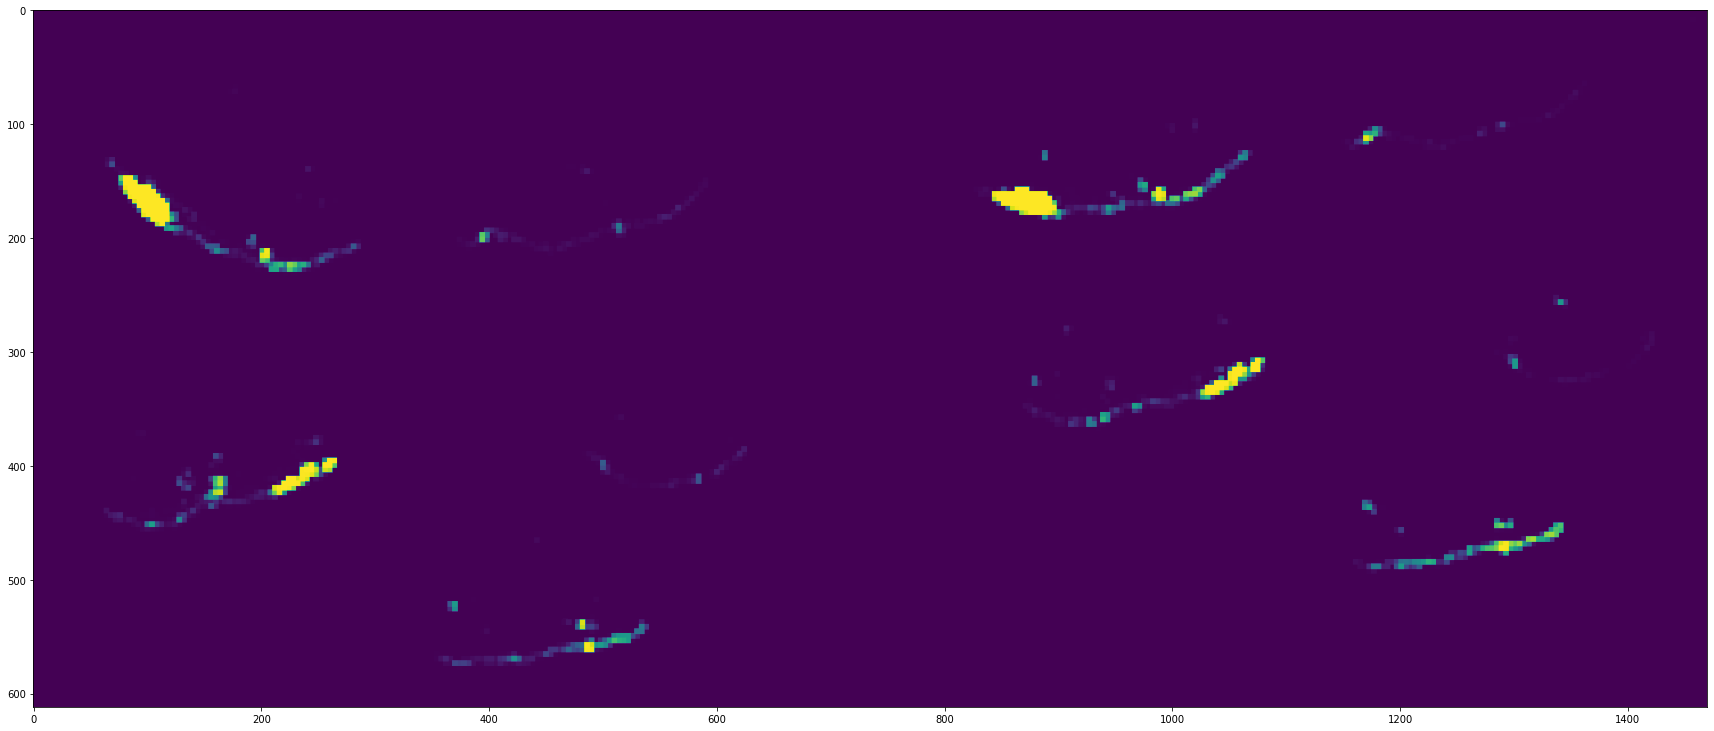

/content/drive/My Drive/Dataset A3/Test/patient11.ndpi
(756, 750)


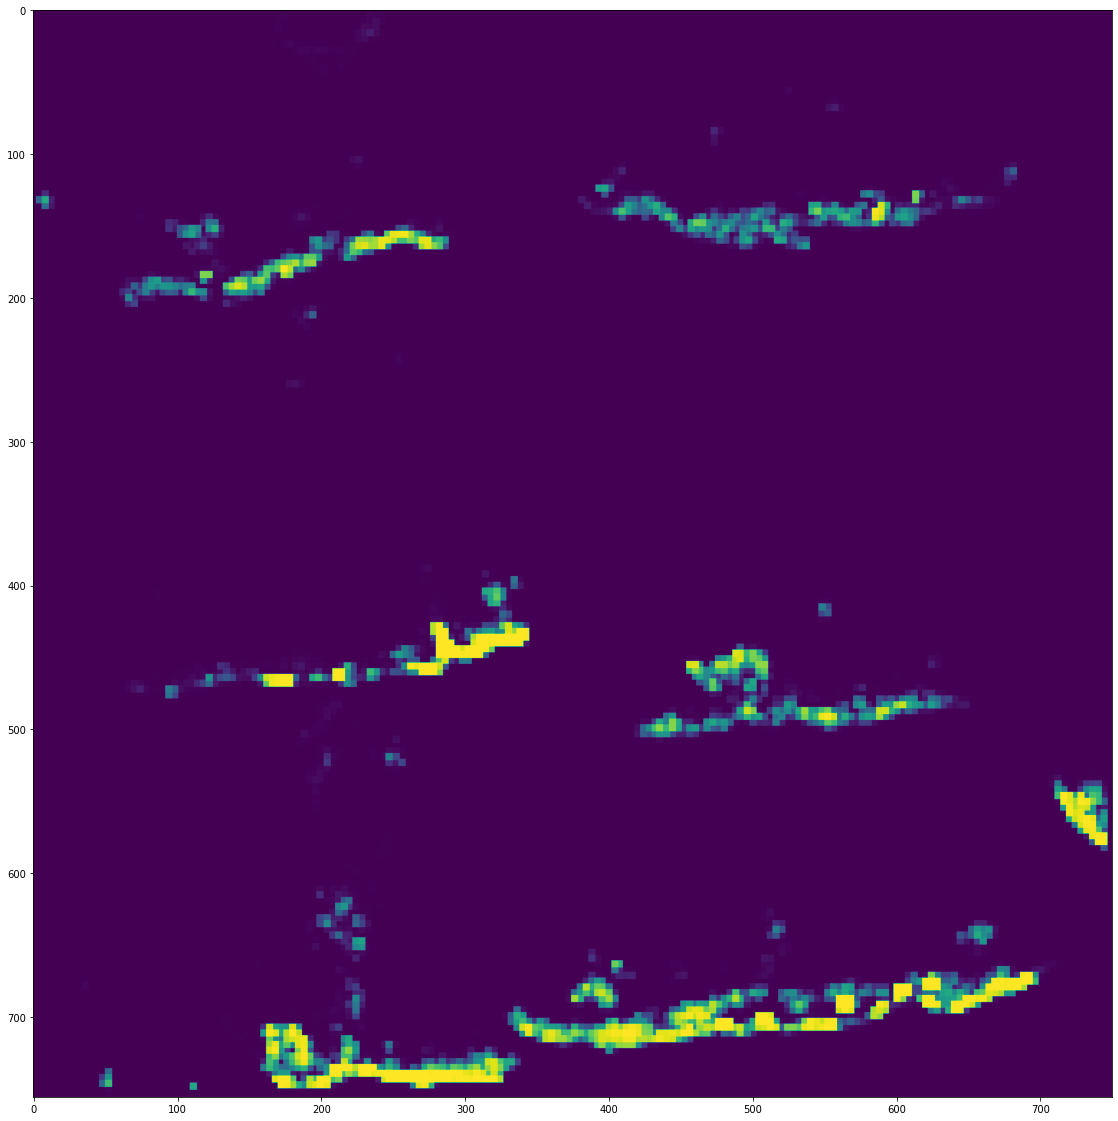

In [57]:
from PIL import Image


def generate_heatmap(slide, patches_dataset):
    model.eval()
    with torch.set_grad_enabled(False):
        level = slide.level_count - 2
        heatmap_width, heatmap_height = slide.get_level_size(level)

        heatmap = np.zeros((heatmap_height, heatmap_width))

        print(heatmap.shape)

        loader = DataLoader(patches_dataset, batch_size=64)

        for images, labels, idx in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.nn.functional.softmax(model(images), 1).detach().cpu()
            probs = outputs[..., 1]
            for i in range(len(idx)):
                patch = patches_dataset.df.iloc[idx[i].item()]
                patch_level = patch['level']
                level_width, level_height = slide.get_level_size(patch_level)

                x, y = patch['x']/level_width, patch['y']/level_height
                patch_width, patch_height  = patch['width']/level_width, patch['height']/level_height
                
                patch_width = int(patch_width * heatmap_width)
                patch_height = int(patch_height * heatmap_height)

                x_start = int(x * heatmap_width) + int(0.25 * patch_width)
                y_start = int(y * heatmap_height) + int(0.25 * patch_height)
                x_end = int(x * heatmap_width) + int(0.75 * patch_width)
                y_end = int(y * heatmap_height) + int(0.75 * patch_height)
                
                heatmap[y_start: y_end + 1, x_start: x_end + 1] = np.maximum(heatmap[y_start: y_end + 1, x_start: x_end + 1], probs[i])

    return heatmap


data_transforms['test'] = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean, std)])

for part in ['train', 'val', 'test']:
    df = pd.read_csv(os.path.join(dataset_path, f'{part}.csv'))
    set_targets(df)

    slides = df['slide'].unique()

    for slide_path in slides:
        print(slide_path)
        slide = Slide(slide_path) 

        slide_df = df[(df['slide'] == slide_path) & (df['source'] == 'tissue')]
        dataset = PatchesDataset(slide_df, data_transforms[part])

        heatmap = generate_heatmap(slide, dataset)

        plt.figure(figsize=(30, 20))
        plt.imshow(heatmap)
        plt.show()

        image = np.asarray(255 * heatmap).astype(np.uint8)
        heatmap_path = os.path.join(results_path, os.path.split(slide_path)[1].replace('.ndpi', '.png'))
        Image.fromarray(image, mode = 'L').save(heatmap_path)